In [1]:
from manim import *

Manim Community v0.17.2

In [12]:
import numpy as np
import math

In [90]:
import torch
import torch.nn as nn


def normal(x, mu, sigma):
    denom = sigma * math.sqrt(2 * math.pi)
    return torch.exp(-((x-mu)**2) / (2 * sigma**2)) / denom


class Function(nn.Module):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.a = 0.005
        self.b = 0.5
        self.t = 12
        self.p = 0.7

        amp1 = 3
        phi1 = 0.7
        amp2 = amp1 * 0.5
        amp1 -= amp2
        phi2 = phi1 * 2

        self.waves = [(amp1, phi1), (amp2, phi2)]

    def forward(self, x, y, requires_grad=False):

        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, requires_grad=requires_grad)
        if not isinstance(y, torch.Tensor):
            y = torch.tensor(y, requires_grad=requires_grad)

        x_quad = self.a*x**2 + self.b
        y_quad = y**2 / ((self.p*self.t)**2) - 2*y/(self.p*self.t) + self.b

        z = x_quad + y_quad

        normal_coef = normal(y, self.p*self.t, self.t / 2)
        for amp, phi in self.waves:
            wave = 1 + torch.cos(phi*x)
            z += normal_coef * amp * wave

        return z

In [91]:
f = Function()

In [92]:
x = torch.tensor(0., requires_grad=True)
y = torch.tensor(0., requires_grad=True)
z = f.forward(x, y)
z

tensor(1.1497, grad_fn=<AddBackward0>)

In [98]:
def create_trajectory(
        start_pos = (0., 0.),
        steps = 100,
        mass = 1.,
        vel = (.1, 0.),
        speed_decay = 0.9,
        v_max = 12
    ):

    pos = torch.tensor(start_pos, requires_grad=True)
    vel = torch.tensor(vel)

    def compute_gradient():
        z = f(*pos)
        z.backward()
        return pos.grad

    grad = compute_gradient()
    trajectory = [(pos.detach().numpy(), grad.detach().numpy())]

    for _ in range(steps):
        vel = speed_decay * (vel - grad / mass)
        pos = torch.tensor(pos + vel, requires_grad=True)

        trajectory.append((pos.detach().numpy(), grad.detach().numpy()))
        grad = compute_gradient()

        if pos[1] > v_max:
            raise ValueError('Trajectory left bounds.')
    
    return trajectory

In [99]:
trajectory = create_trajectory()
trajectory_nudge = create_trajectory(start_pos=trajectory[-1][0], vel=(-.7, 0.4))
trajectory_2 = create_trajectory(vel=(-1.1, 0.))

C:\Users\dylan\AppData\Local\Temp\ipykernel_12360\1625790550.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos = torch.tensor(pos + vel, requires_grad=True)


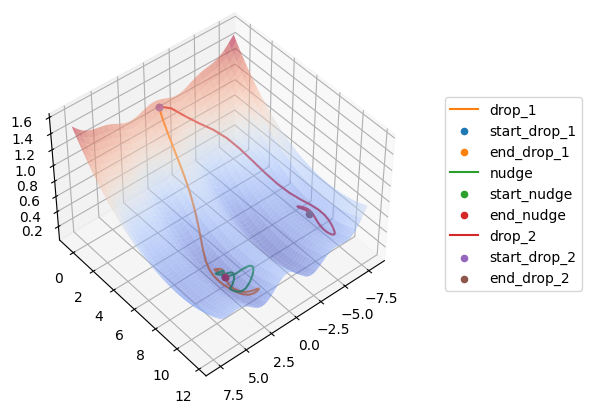

In [95]:
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=45., azim=50)

X = np.arange(-8, 8, 0.25)
Y = np.arange(-0.5, 12, 0.25)
X, Y = np.meshgrid(X, Y)

Z = f(X, Y, requires_grad=False)

from matplotlib import cm
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, alpha=0.5,
                       linewidth=0, antialiased=True)

name = {
    0: 'drop_1', 1: 'nudge', 2: 'drop_2'
}

# Prepare arrays x, y, z
for i, traj in enumerate([trajectory, trajectory_nudge, trajectory_2]):
    z = np.linspace(-2, 2, 100)
    positions = np.array([pos for pos, _ in traj])
    x, y = positions[:, 0], positions[:, 1]
    z = f(x, y).detach().numpy() + 0.1

    ax.plot(x, y, z, label=name[i])
    ax.scatter(x[0], y[0], z[0], label=f'start_{name.get(i)}')
    ax.scatter(x[-1], y[-1], z[-1], label=f'end_{name.get(i)}')

# put a legend to the left of the plot
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.show()

In [100]:
from manim import UpdateFromAlphaFunc, RED, Dot3D, TracedPath


def create_linear_curve(traj) -> callable:
    
    def f(t) -> np.ndarray:
        i = int(t * len(traj))
        if i < 0:
            return traj[0][0]
        if i >= len(traj):
            return traj[-1][0]

        pos, _ = traj[i]
        if i == len(traj) - 1:
            return pos

        next_pos, _ = traj[i+1]
        
        p = t - i / len(traj)
        return pos + (next_pos - pos) * p

    return f


class TraverseSurface(UpdateFromAlphaFunc):

    def __init__(self,
                 axes,
                 surface_fn,
                 trajectory,
                 dot=None,
                 dot_radius=0.2,
                 dot_colour=RED,
                 trace_path=True,
                 trace_width=4,
                 trace_dissipating_time=None):
        self.axes = axes
        self.surface_fn = surface_fn
        self.trace_path = trace_path
        self.trace_width = trace_width
        self.trace_dissipating_time = trace_dissipating_time

        self.path = create_linear_curve(trajectory)
        
        if dot is None:
            self.dot_radius = dot_radius
            self.dot_colour = dot_colour
            self.dot = Dot3D(point=self.get_point_at(0),
                             color=dot_colour,
                             radius=dot_radius)
        else:
            self.dot_radius = dot_radius
            self.dot_colour = dot.color
            self.dot = dot

        super().__init__(self.dot, self.update)

    def get_point_at(self, t):
        dot_x, dot_y = self.path(t)
        dot_z = self.surface_fn(dot_x, dot_y)
        return self.axes.coords_to_point(dot_x, dot_y, dot_z)

    def update(self, iteration, t):
        self.dot.move_to(self.get_point_at(t))
        return iteration
    
    def get_all_mobjects(self):
        if self.trace_path:
            tracer = TracedPath(self.dot.get_center,
                                stroke_color=self.dot_colour,
                                stroke_width=self.trace_width,
                                dissipating_time=self.trace_dissipating_time,
                                stroke_opacity=[0, 1])
            return super().get_all_mobjects() + (tracer,)

        return super().get_all_mobjects()

In [130]:
%%manim --disable_caching WaddingtonLandscape


class WaddingtonLandscape(ThreeDScene):
    
    def construct(self):
        from functools import cache

        def func(u, v):
            return f(u, v).numpy().item()
        
        self.surface_fn = cache(func)

        self.build_surface()
        self.drop_animations()

    def get_schedule(self):
        return {
            'wait_before_rise': 1,
            'surface_rise': 3,
            'wait_before_uncreate_axes': 7,
            'wait_before_drop_1': 10,
            'stem_cell_text': 2,
            'drop_1': 5,
            'neuron_text': 2,
            'wait_before_nudge': 7,
            'nudge': 5,
            'wait_before_drop_2': 7,
            'drop_2': 3,
            'liver_cell_text': 2,
            'wait_after_drop_2': 7,
        }

    def get_total_time(self):
        return sum(self.get_schedule().values())
    
    def build_surface(self):
        self.axes = ThreeDAxes(x_range=(-5, 5, 1),
                               y_range=(-0.5, 10, 1),
                               z_range=(0, 1, 0.5))

        resolution_fa = 32
        u_max = 8
        v_min, v_max = -1, 12
        def create_surface(f):
            surface = Surface(
                lambda u, v: self.axes.c2p(u, v, f(u, v)),
                resolution=(resolution_fa, resolution_fa),
                v_range=[v_min, v_max],
                u_range=[-u_max, u_max],
            )
            surface.set_style(fill_opacity=1)
            surface.set_fill_by_value(axes=self.axes,
                                      colorscale=[(RED_C, 0), (DARK_BLUE, 2*b)],
                                      axis=2)
            return surface

        self.set_camera_orientation(phi=0 * DEGREES, theta=0, zoom=0.4,
                                    frame_center=(0, 0, 2), run_time=3)
        
        surface = create_surface(lambda u, v: 0)

        brace = Brace(surface, stroke_width=3)
        with register_font('./FiraCode-Retina.ttf'):
            brace_text = Text("Space of\nPossible\nCells",
                              font='Fira Code Retina', font_size=80)

        brace_text.rotate(90 * DEGREES, about_point=brace_text.get_center())
        brace_text.next_to(brace, np.array([0, -1, 0]), buff=1)
        
        self.add(surface)
        self.wait(1)
        self.play(Create(brace), Create(brace_text), run_time=2)
        
        schedule = self.get_schedule()
        self.wait(1)

        start_angle = 25
        change_angle = 100 - start_angle
        self.move_camera(phi=45 * DEGREES,
                         theta=start_angle * DEGREES,
                         zoom=.3, frame_center=(0, 0, 2),
                         added_anims=[Uncreate(brace), Uncreate(brace_text)])

        total_time = self.get_total_time()
        self.begin_ambient_camera_rotation(rate=change_angle * DEGREES / total_time)
        
        self.wait(schedule['wait_before_rise'])

        def create_line_with_text(t):
            p1 = self.axes.coords_to_point(u_max, 0, 0)
            p2 = self.axes.coords_to_point(u_max, 0, t * self.surface_fn(u_max, 0))

            line = Line3D(start=p1, end=p2)

            with register_font('./FiraCode-Retina.ttf'):
                line_text = Text("Pluripotency",
                                 font='Fira Code Retina', font_size=80, fill_opacity=t)

            line_text.rotate(90 * DEGREES, about_point=brace_text.get_center(), axis=[0, 1, 0])
            line_text.rotate(90 * DEGREES, about_point=brace_text.get_center(), axis=[0, 0, 1])
            line_text.next_to(line, np.array([1, 0, 0]), buff=1)

            return line, line_text

        def update(iteration, t):
            surface = create_surface(lambda u, v: t * self.surface_fn(u, v))
            line, line_text = create_line_with_text(t)
            iteration.become(VGroup(surface, line, line_text))
            return iteration

        line, line_text = create_line_with_text(0)
        self.play(UpdateFromAlphaFunc(VGroup(surface, line, line_text), update),
                  run_time=schedule['surface_rise'])

        self.wait(schedule['wait_before_uncreate_axes'])
        self.play(Uncreate(line), Uncreate(line_text))

    def drop_animations(self):
        schedule = self.get_schedule()
        self.wait(schedule['wait_before_drop_1'])

        (x, y), _ = trajectory[0]
        self.text_above_surface('Stem Cell', x, y, height=.2, run_time=schedule['stem_cell_text'])
        
        surface_traverse = TraverseSurface(self.axes,
                                           self.surface_fn,
                                           trajectory,
                                           dot_colour=YELLOW,
                                           trace_dissipating_time=5)
        
        self.add(*surface_traverse.get_all_mobjects())
        self.play(surface_traverse, run_time=schedule['drop_1'], rate_func=linear)
        
        (x, y), _ = trajectory[-1]
        self.text_above_surface('Neuron', x, y, height=1.2, run_time=schedule['neuron_text'])
    
        # second wait
        self.wait(schedule['wait_before_nudge'])

        # nudge first ball
        nudge_red_dot = TraverseSurface(self.axes,
                                        self.surface_fn,
                                        trajectory_nudge,
                                        dot=surface_traverse.dot,
                                        trace_dissipating_time=5)
        self.add(*nudge_red_dot.get_all_mobjects())
        self.play(nudge_red_dot, run_time=schedule['nudge'], rate_func=linear)

        self.wait(schedule['wait_before_drop_2'])
        
        # second drop
        surface_traverse_2 = TraverseSurface(self.axes, 
                                             self.surface_fn,
                                             trajectory_2,
                                             dot_colour=BLUE,
                                             trace_dissipating_time=5)
        self.add(*surface_traverse_2.get_all_mobjects())
        self.play(surface_traverse_2, run_time=schedule['drop_2'], rate_func=linear)

        (x, y), _ = trajectory_2[-1]
        self.text_above_surface('Liver Cell', x, y, height=1.1, run_time=schedule['liver_cell_text'])

        # third wait
        self.wait(schedule['wait_after_drop_2'])

    def text_above_surface(self, text, x, y, height=1.2, run_time=1.5, colour=WHITE):
        z = self.surface_fn(x, y)
        start = self.axes.coords_to_point(x, y, z)
        end = self.axes.coords_to_point(x, y, z + height)
        line = DashedLine(start, end, dash_length=0.3, stroke_width=5, color=colour)
        self.play(Create(line), run_time=run_time/2)
        
        with register_font('./FiraCode-Retina.ttf'):
            text = Text(text, font='Fira Code Retina',
                        color=colour, stroke_color=colour,
                        font_size=60, stroke_width=2)

        text.next_to(line, np.array([0, 0, 1]), buff=0.75)
        text.rotate(90*DEGREES, axis=np.array([1, 0, 0]), about_point=text.get_center())
        text.rotate(180*DEGREES, axis=np.array([0, 0, 1]), about_point=text.get_center())
        self.play(Create(text), run_time=run_time/2)

[01/03/23 03:31:56] INFO     Caching disabled.                                                 ]8;id=462821;file://C:\tools\Manim\Lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=6415;file://C:\tools\Manim\Lib\site-packages\manim\renderer\cairo_renderer.py#68\68]8;;\

[01/03/23 03:31:57] INFO     Animation 0 : Partial movie file written in                   ]8;id=410601;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=993599;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                             'C:\Users\dylan\OneDrive\Video\ProtoEvo\manim\media\videos\ma                         
                             nim\1080p60\partial_movie_files\WaddingtonLandscape\uncached_                         
                             00000.mp4'                                                                            

                    INFO     Caching disabled.                                                 ]8;id=11274;file://C:\tools\Manim\Lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=498119;file://C:\tools\Manim\Lib\site-packages\manim\renderer\cairo_renderer.py#68\68]8;;\

[01/03/23 03:32:00] INFO     Animation 1 : Partial movie file written in                   ]8;id=563888;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=53127;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                             'C:\Users\dylan\OneDrive\Video\ProtoEvo\manim\media\videos\ma                         
                             nim\1080p60\partial_movie_files\WaddingtonLandscape\uncached_                         
                             00001.mp4'                                                                            

                    INFO     Caching disabled.                                                 ]8;id=85409;file://C:\tools\Manim\Lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=837478;file://C:\tools\Manim\Lib\site-packages\manim\renderer\cairo_renderer.py#68\68]8;;\

[01/03/23 03:32:01] INFO     Animation 2 : Partial movie file written in                   ]8;id=441699;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=390457;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                             'C:\Users\dylan\OneDrive\Video\ProtoEvo\manim\media\videos\ma                         
                             nim\1080p60\partial_movie_files\WaddingtonLandscape\uncached_                         
                             00002.mp4'                                                                            

                    INFO     Caching disabled.                                                 ]8;id=74959;file://C:\tools\Manim\Lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=653931;file://C:\tools\Manim\Lib\site-packages\manim\renderer\cairo_renderer.py#68\68]8;;\

[01/03/23 03:32:42] INFO     Animation 3 : Partial movie file written in                   ]8;id=930673;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=305992;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                             'C:\Users\dylan\OneDrive\Video\ProtoEvo\manim\media\videos\ma                         
                             nim\1080p60\partial_movie_files\WaddingtonLandscape\uncached_                         
                             00003.mp4'                                                                            

                    INFO     Caching disabled.                                                 ]8;id=216601;file://C:\tools\Manim\Lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=722747;file://C:\tools\Manim\Lib\site-packages\manim\renderer\cairo_renderer.py#68\68]8;;\

[01/03/23 03:33:22] INFO     Animation 4 : Partial movie file written in                   ]8;id=296033;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=992599;file://C:\tools\Manim\Lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                             'C:\Users\dylan\OneDrive\Video\ProtoEvo\manim\media\videos\ma                         
                             nim\1080p60\partial_movie_files\WaddingtonLandscape\uncached_                         
                             00004.mp4'                                                                            

[01/03/23 03:33:24] INFO     Caching disabled.                                                 ]8;id=779655;file://C:\tools\Manim\Lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=448956;file://C:\tools\Manim\Lib\site-packages\manim\renderer\cairo_renderer.py#68\68]8;;\

Animation 5: UpdateFromAlphaFunc(VGroup of 3 submobjects):  95%|#########5| 171/180 [45:14<02:18, 15.43s/it]

In [ ]:
from functools import cache

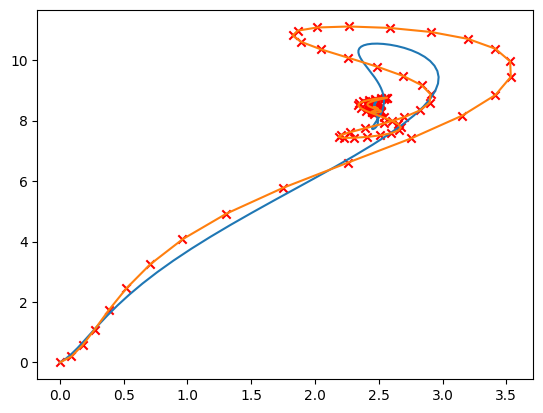

In [132]:
positions = np.array([pos for pos, _ in trajectory])

T = np.linspace(0, 1, 200)

f = bezier(positions)
points = np.array([f(t) for t in T])
plt.plot(points[:, 0], points[:, 1])

f = create_linear_curve(trajectory)
points = np.array([f(t) for t in T])
plt.plot(points[:, 0], points[:, 1])


plt.scatter(positions[:, 0], positions[:, 1], marker='x', color='r')

plt.show()